In [2]:
# start by loading data on the returns of the market portfolio and the risk-free rate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Momentum portfolios

**Momentum** is the fact that stocks that have performed
relatively well in the past continue to perform
relatively well in the future, and stocks that have performed
relatively poorly, continue to perform relatively
poorly.

A Momentum investment or “relative strength”
strategy buys stocks which have performed relatively
well in the past and sells (shorts) stocks which have performed
relatively poorly.
Over the 1963-1990 time period, Jegadeesh and Titman
(1993) found that a strategy that ranked stocks based on
their past 6 months to a year returns, and bought the top
10% and shorted the bottom 10% based on this ranking,
produced abnormal returns of 12% per year.


Momentum portfolios bet on **cross-sectional** continuation. That is, in a stock did well relative to others in the recent past, the bet is that will continue to do better than the average going forward. 

In some ways momentum is the opposite of value , since value stocks are stocks that have had very low returns (how else they would be value?)

The difference--and every detail matter- is that value/growth focus on  the valuation ratio as as the signal of how low the price is. So the valaution ratio captures the entire history of returns (what is price if not the result of the historical returns).Momentum instead focus on the last 12 months. Recent, but not too recent. 

As we will see the strategy works best when you actually skip one month between the return signal and the portfolio construction.

**Past Return Predictability in General**

1. Long-term reversals
   - DeBondt and Thaler (1985)
   - 3-5 year contrarian strategy

2. Short-term (< 1 month) reversals
   - Jegadeesh (1990), Lehman (1990), Lo andMacKinlay (1988)

3. Intermediate horizon continuation
   - Jegadeesh and Titman (1993)
   - 3-12 month momentum strategy
   - profits dissipate over 1-year and start to reverse after 2-3 years -> temporary price effect.
   - see similar pattern around earnings announcements (both earnings and price momentum).



**Why this might work?**

Momentum in lots of way it is much more puzzling than value for rational theories. My perception is that the majority of theories proposed to explain moementum can't really make sense of it quantitatively.

* Behaviroal story: The idea here is that markets might be slow to incorporate information, so good/bad news gets into prices slowly over time. (for example investors might only slowly get into prices the consequences of covid-19. They do, but they jsut don't do enough of it)

* Rational story: Maybe all these stocks are exposed to the same missing risk-factor. They all went up and down at the same time after all! For example all firms that went down in march 2020 are particularly exposed to Covid and the ones that did well are positively exposed. So they will move togehter as COVID risk fluctuate. It is hard to use a story liek that to explain the premium, but it is easy to see how it explians the co-movement.

* My overall sense is that the majority of academics think that momentum is driven by "behavioral" factors. Note however that momentum tends to crash very badly in high volatiltiy periods such as 2008 and 2020, so it is certainly risky if you zoom out a bit.

**Literature**

Lots of work on this. 

1. [Here is a review of the work on the momentum strategy](https://www.annualreviews.org/doi/full/10.1146/annurev-financial-102710-144850)


2. [Here is the paper that first documented the Momentum profitability](https://www.jstor.org/stable/pdf/2328882.pdf?casa_token=wjU0QYjZvg4AAAAA:aAxgJJLpR7VexgbmcWBBUMveRXin7d5VpGkrYIXDm_UseOs_ETYRZWSNLHzmkGrDFk5A4PNvA6nI8JY4k5khKlSDucppwJ1JNlx0GGqQthOQ4uBY6cA)

3. [Here is Daniel and Moskowitz analysis of momentum](https://github.com/amoreira2/Lectures/blob/a1f2e6ef36e80d32ee12a391b878f564f15c3cd5/assets/papers/Daniel%20Moskowitz%202015.pdf)

**Construction**

Here is how Daniel and Moskowitz construct their portfolios


>To form the momentum portfolios, we first rank stocks based on their cumulative returns
from 12 months before to one month before the formation date (i.e., the t-12 to t-2-month
returns), where, consistent with the literature (Jegadeesh and Titman, 1993, Asness, 1994,
Fama and French, 1996), we use a one month gap between the end of the ranking period and
the start of the holding period to avoid the short-term reversals documented by Jegadeesh
(1990) and Lehmann (1990). In particular we will focus on 10% and 90% quantiles of the signal distribution and will construct portfolios of all stocks that are in the bottom and top quantiles

**Load return and market cap data by firm/date**

In [5]:
#load our data
url = "https://raw.githubusercontent.com/amoreira2/Lectures/main/assets/data/value_characteristic.csv"
parser = lambda date: pd.to_datetime(date,format='%m%y')
Data = pd.read_csv(url,parse_dates=[0])
# This simply shits the date to be in an end of month basis
Data.date=Data.date+pd.tseries.offsets.MonthEnd()
Data.rename(columns={'size':'log_mcap'},inplace=True)
Data=Data.drop(columns=['value'])
Data.tail(5)

,date,permno,re,rf,log_mcap
0,1972-07-31,10006,0.028600,0.0031,12.399869
1,1972-07-31,10102,0.039757,0.0031,12.217334
2,1972-07-31,10137,-0.044767,0.0031,13.069874
3,1972-07-31,10145,-0.062422,0.0031,13.608366
4,1972-07-31,10153,-0.065600,0.0031,11.752572
...,...,...,...,...,...
486422,2016-12-31,93420,0.011056,0.0003,14.337515
486423,2016-12-31,93422,-0.063881,0.0003,15.256946
486424,2016-12-31,93423,0.039950,0.0003,15.502888
486425,2016-12-31,93429,0.072124,0.0003,15.504722


**Construct the signal**



1. Lets add the risk-free rate so we work with returns

2. construct gross returns $(1+r)$ so we can cumulate the returns

$$r_{t-11,t}=(1+r_{t-11})(1+r_{t-10})..(1+r_{t-1})(1+r_{t})$$


3. Set index to date, this will make the data stay on the data set when when use the groupby method below.

    - You should think this more of a trick, since date obviously cannot be index of this data set since you need the permno as well to fully idendify an observation.

In [37]:
df=Data.copy()
df['r']=df.re+df.rf
del df['re']
df['R']=(df['r']+1)
df=df.set_index(['date'])
df.tail(6)

,permno,rf,log_mcap,r,R
date,,,,,
2016-12-31,93374,0.0003,15.298729,-0.020403,0.979597
2016-12-31,93420,0.0003,14.337515,0.011356,1.011356
2016-12-31,93422,0.0003,15.256946,-0.063581,0.936419
2016-12-31,93423,0.0003,15.502888,0.040250,1.040250
2016-12-31,93429,0.0003,15.504722,0.072424,1.072424
2016-12-31,93436,0.0003,17.262975,0.128247,1.128247


We will now cumulate the reutrns of each asset ona rolling basis,

As described in the procedure we wll look back for 11 months and compute the cumulative reutrn in the period.

We will later use the `shift` method to get the lags correct.

But here what is important is that the we will be grouping by `permno` and applying the `rolling()` operator, we will them apply the fuction `np.prod` which returns the product of the variables in the group, we then take `-1` so we have simple cumulative returns agrain which we label `cumret11`

In [38]:
temp=(df.groupby('permno')[['R']]).rolling(window=11,min_periods=7).apply(np.prod, raw=True)-1
temp=temp.rename(columns={'R':'cumret11'})
temp =temp.reset_index()
del df['R']
temp.tail(5)


,permno,date,cumret11
486422,93436,2016-08-31,-0.146498
486423,93436,2016-09-30,-0.014014
486424,93436,2016-10-31,-0.141275
486425,93436,2016-11-30,-0.210866
486426,93436,2016-12-31,0.117626


1. We now merge back this `cumret11` variable with our data set

   - We will reset the `df` index so both `permno` and `date` are normal columns.

   - I don't quite get how the merge works with two indexes, it just seems way slower

2. We lag the signal by two months. The first month to make sure the signal is tradable, so that is mandatory otherwise our signal would include the return we are trading on , so the strategy would be invalid. We do `2` because we will be skipping a month so we cumulate returns up to t-2, and form the portfolio in beggining of month t, so return t-1 does not go either in the signal or our strategy
   
   - Before lagging it always important to sort the values so the result is what you intendended
   
3. We finally drop and firm/date pair that does not have our momentum signal (maybe didn't trade)

In [39]:
temp = pd.merge(df.reset_index(), temp[['permno','date','cumret11']], how='left', on=['permno','date'])
temp=temp.sort_values(['date','permno'])
temp['mom']=temp.groupby('permno')['cumret11'].shift(2)
# why I am groupby permno here befroe lagging?
# drop the row if any of 'mom' is missing
temp=temp.dropna(subset=['mom'], how='any')
temp.tail()

,date,permno,rf,log_mcap,r,cumret11,mom
486422,2016-12-31,93420,0.0003,14.337515,0.011356,-0.496086,-0.627295
486423,2016-12-31,93422,0.0003,15.256946,-0.063581,-0.049676,-0.280089
486424,2016-12-31,93423,0.0003,15.502888,0.040250,0.245348,0.107236
486425,2016-12-31,93429,0.0003,15.504722,0.072424,0.125006,-0.112178
486426,2016-12-31,93436,0.0003,17.262975,0.128247,0.117626,-0.141275


**Group assets by signal**


* We have our trading signal for each stock in each date.

* We now need to assign groups to each stocks. These groups will identify to which portfolio each stock belongs in a particular date

* We will do this by applying the function `pd.qcut` to the `mom` signal. This will "cut" the signal distribution in the chosen number of groups. 

* The important aspects is that we will applying this date by date. This make the strategy cross-sectional becasue you are usign the distribution of the signal as given date to the grouping

* Details
   - `duplicates='drop'`: In case there are two stocks with exactly the same signal that are exactly in the cutoff of the groups, we drop one of the observations 
   - ` labels=False`: The method simply label the groups with numbers. For example if `ngroups=10` then it will assign `0` to the stocks with the  bottom 10% returns in a given date, `1` to stocks with returns in between 10% and 20% of the return distribution on a given date, ..., and 9 for stocks in the top 10% (return in between 90% and 100% of the return distribution on a given date) .

In [40]:
ngroups=10
temp['mom_group']=temp.groupby(['date'])['mom'].apply(lambda x: pd.qcut(x, ngroups, \
                                                                       labels=False, duplicates='drop'))
mom.tail(6)

,date,permno,rf,log_mcap,r,cumret11,mom,mom_group
486421,2016-12-31,93374,0.0003,15.298729,-0.020403,0.099421,0.019303,4
486422,2016-12-31,93420,0.0003,14.337515,0.011356,-0.496086,-0.627295,0
486423,2016-12-31,93422,0.0003,15.256946,-0.063581,-0.049676,-0.280089,0
486424,2016-12-31,93423,0.0003,15.502888,0.040250,0.245348,0.107236,6
486425,2016-12-31,93429,0.0003,15.504722,0.072424,0.125006,-0.112178,2
486426,2016-12-31,93436,0.0003,17.262975,0.128247,0.117626,-0.141275,1


We finally simply construct the returns by adding up the returns for a given data within a group weighting by the market caps

In [41]:
mom_mw = temp.groupby(['date','mom_group']).apply(lambda x:(x.r*np.exp(x.log_mcap)).sum()/np.exp(x.log_mcap).sum())
mom_mw=mom_mw.unstack(level=-1) # unstack so we have in each column the different portfolios, and in each 
# row the different dates
mom_mw.tail()


mom_group,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2016-08-31,0.035752,0.029992,0.023031,0.016375,0.009395,0.008424,-0.007936,-0.005078,-0.019950,-0.017332
2016-09-30,0.029610,0.004987,-0.006927,-0.015518,0.005926,0.000237,-0.001918,-0.000691,-0.003284,0.016097
2016-10-31,-0.035750,-0.008137,-0.006318,0.009914,-0.010287,-0.004815,-0.026976,-0.035124,-0.023977,-0.029326
2016-11-30,0.078938,0.109157,0.042896,0.059222,0.065606,0.037473,0.031247,0.023967,0.010877,0.012137
2016-12-31,-0.001706,0.027173,0.023992,0.020563,0.011224,0.021446,0.028039,0.021267,0.017929,0.000409


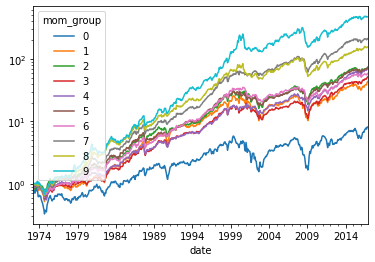

In [42]:
(mom_mw+1).cumprod().plot(logy=True)
plt.show()

**Building a fucntion that does it all**

We simply put together the pieces of code so with a function call we can generate the time-series of returns of the strategy for different parameters (lookbak? Skip?)

In [51]:
# put it all together in a fuction
def momentum(df,ngroups=10,lookback=11,skip=2):
    df['r']=df.re+df.rf
    df['R']=(df['r']+1)
    df=df.set_index(['date'])
    temp=(df.groupby('permno')[['R']]).rolling(window=lookback,min_periods=int(np.ceil(lookback))).apply(np.prod, raw=True)-1
    temp=temp.rename(columns={'R':'cumret11'})
    temp =temp.reset_index()
    temp = pd.merge(df.reset_index(), temp[['permno','date','cumret11']], how='left', on=['permno','date'])
    temp=temp.sort_values(['date','permno'])
    temp['mom']=temp.groupby('permno')['cumret11'].shift(skip)
    temp=temp.dropna(subset=['mom'], how='any')
    ngroups=10
    temp['mom_group']=temp.groupby(['date'])['mom'].apply(lambda x: pd.qcut(x, ngroups, \
                                                                           labels=False, duplicates='drop'))
    mom_mw = temp.groupby(['date','mom_group']).apply(lambda x:(x.r*np.exp(x.log_mcap)).sum()/np.exp(x.log_mcap).sum())
    mom_mw=mom_mw.unstack(level=-1)
    
    return mom_mw
    

In [52]:
momentum(Data,ngroups=10,lookback=11,skip=2)

mom_group,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
1973-07-31,0.138562,0.151917,0.101294,0.105704,0.095031,0.068058,0.022860,0.032756,0.023754,0.013785
1973-08-31,-0.046980,-0.045063,-0.043584,-0.014019,-0.040480,-0.029794,-0.019756,-0.038747,-0.041360,-0.027852
1973-09-30,0.126599,0.147847,0.125030,0.109003,0.093934,0.050818,-0.017574,0.026172,0.035517,0.051186
1973-10-31,-0.063320,-0.025045,-0.017627,-0.048870,-0.040870,0.023309,-0.000141,-0.007314,0.008722,0.049831
1973-11-30,-0.230409,-0.175438,-0.092886,-0.151315,-0.136741,-0.107225,-0.097161,-0.114968,-0.068584,-0.084331
...,...,...,...,...,...,...,...,...,...,...
2016-08-31,0.035971,0.030158,0.023274,0.016611,0.009291,0.008441,-0.008164,-0.007541,-0.018152,-0.017833
2016-09-30,0.028696,0.005607,-0.006929,-0.014986,0.005210,0.000132,-0.001332,-0.000689,-0.003161,0.016226
2016-10-31,-0.035871,-0.008048,-0.005419,0.009697,-0.003015,-0.005182,-0.027022,-0.035140,-0.024286,-0.029026


**The General Recipe**

1. Decide on a trading signal (last 12 month return, Book/Market,beta,...)

2. Calculate the trading signal for each stock

3. Group the stocks according to the strength of the trading signal
    
    - must choose the number of groups, i.e. number of portfolios
    
    - If you choose very few (lets say two)
      - you get the benefit from diversification
      - but also suffer from the cost of having only a small spread on the strength of the trading signal across portfolios
    
    - If you choose a lot of groups (say 100)
      - you benefit from having a large spread in the trading signal
      - but there are just very few stocks in each portfolio, so you will have a very volatile portfolio 
        - Portfolio 100 only has really strong stocks
        - Portfolio 1 only has really weak stocks   
    
    
4. You have to decide how to weight the stocks within each bin

     - Value-weighting makes your strategy more likely to be traded at low cost
     
     - Equal-weighting can sometimes provide more diversification

**Other "returns" based strategies**

One can easily adapt the code to reproduce a variety of investment strategies that only rely on return information, broadly described as "technical" strategies

1. Short-term Reversals: Sort stocks based on returns in month t-1, but in the beggining of month t

2. Long-term reversals: Sort on cumulative returns of the last 5 years

3. Volatility: sort on the return volatiltiy of the last 24 months, say using returns between t-24 to t-1 and form the portfolio in beggining of date t.

4. (HARDER) Market beta: Sort stocks based on their beta with the market porfolio. Say estimate beta using the last 60 months of data (t-60 to t-1) and form portfolio at the beggining of date t.

Below is a plot that summarizes the emprical evidence on return-based strategies. It shows the Sharpe Ratio as a function of the lookback period of the reutrn signal


![image.png](../../assets/plots/Momentum1.jpg)

* Can you reproduce this plot?